In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random, gc, keras, os

from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

%matplotlib inline

Using TensorFlow backend.


# Load Data

In [2]:
train_df = pd.read_csv('./data/triplet/train.csv')
val_df = pd.read_csv('./data/triplet/validation.csv')
test_df = pd.read_csv('./data/triplet/test.csv')

print('Train:\t\t', train_df.shape)
print('Validation:\t', val_df.shape)
print('Test:\t\t', test_df.shape)

print('\nTrain Landmarks:\t', len(train_df['landmark_id'].unique()))
print('Validation Landmarks:\t', len(val_df['landmark_id'].unique()))
print('Test Landmarks:\t\t', len(test_df['landmark_id'].unique()))

Train:		 (113783, 4)
Validation:	 (22255, 4)
Test:		 (22391, 4)

Train Landmarks:	 14943
Validation Landmarks:	 7674
Test Landmarks:		 14436


In [3]:
train_df.head()

,image_id,id,url,landmark_id
0,465272,a2ccf8ed2e969f6a,https://lh4.googleusercontent.com/-TPHkS5gzvm4...,0
1,64516,e205ca7c8dd7c027,https://lh3.googleusercontent.com/-V3RjsZtGpxE...,0
2,928409,4e8ab93c1620e8a3,http://mw2.google.com/mw-panoramio/photos/medi...,0
3,88809,896bf928214d1ca4,http://lh5.ggpht.com/-Cy0l41uUaGA/R--yB8vy41I/...,0
4,1001133,375d2a153bdca926,http://lh6.ggpht.com/-UqzFpnqE9bU/S_0u1RovfdI/...,0


# Helper Functions

In [4]:
# read all images
def get_all_images(df, img_size=(224, 224), prefix='./data/triplet/train'):
    """ get all test images """
    img_ids = df['image_id'].values
    landmark_ids = df['landmark_id'].values
    images = []
    
    for idx in img_ids:
        path = prefix + str(idx) + '.jpg'
        tmp_img = load_img(path, target_size=img_size)
        tmp_img = img_to_array(tmp_img)
        images.append(tmp_img)
        
    # transform list to array
    images = np.array(images, dtype=K.floatx()) / 255.0
    
    return images

In [5]:
# training set triplet generator
def train_triplet_generator(df, batch_size=74, img_size=(224, 224), seed=42, 
                            prefix='./data/triplet/train/'):
    """ training set triplet generator
        it will generate 7400 triplet images in total
    """
    # get images with only one training image landmark id and the rest landmark ids
    np.random.seed(seed)
    grouped = df[['landmark_id', 'image_id']].groupby('landmark_id').count().reset_index()
    unique_neg_ids = list(grouped[grouped['image_id'] == 1]['landmark_id'].values)
    rest_ids = list(grouped[grouped['image_id'] > 1]['landmark_id'].values)
    size = 7400 * 2 - len(unique_neg_ids) 
    zeros = np.zeros((batch_size, 1), dtype=K.floatx())
    
    while True:
        # get positive and negative image landmark ids
        np.random.shuffle(rest_ids)
        candidate_ids = list(np.random.choice(rest_ids, size=size, replace=False))
        pos_landmark_ids = candidate_ids[:7400]
        neg_landmark_ids = candidate_ids[7400:] + unique_neg_ids
        np.random.shuffle(neg_landmark_ids)
        
        # transform landmark id into image id
        anc_img_ids = []
        pos_img_ids = []
        neg_img_ids = []
        
        for i in range(len(pos_landmark_ids)):
            tmp_pos_ids = df[df['landmark_id'] == pos_landmark_ids[i]]['image_id'].values
            anc_img_ids.append(tmp_pos_ids[0])
            pos_img_ids.append(tmp_pos_ids[1])
            
            tmp_neg_ids = df[df['landmark_id'] == neg_landmark_ids[i]]['image_id'].values
            neg_img_ids.append(tmp_neg_ids[0])
        
        # iterator to read batch images
        for j in range(len(pos_img_ids) // batch_size):
            batch_anc_img_ids = anc_img_ids[j * batch_size: (j + 1) * batch_size]
            batch_pos_img_ids = pos_img_ids[j * batch_size: (j + 1) * batch_size]
            batch_neg_img_ids = neg_img_ids[j * batch_size: (j + 1) * batch_size]
            
            # get images
            anc_imgs = []
            pos_imgs = []
            neg_imgs = []
            
            # iteratively read images
            for k in range(batch_size):
                anc_path = prefix + str(batch_anc_img_ids[k]) + '.jpg'
                pos_path = prefix + str(batch_pos_img_ids[k]) + '.jpg'
                neg_path = prefix + str(batch_neg_img_ids[k]) + '.jpg'
                
                tmp_anc_img = load_img(anc_path, target_size=img_size)
                tmp_anc_img = img_to_array(tmp_anc_img)
                anc_imgs.append(tmp_anc_img)
                
                tmp_pos_img = load_img(pos_path, target_size=img_size)
                tmp_pos_img = img_to_array(tmp_pos_img)
                pos_imgs.append(tmp_pos_img)
                
                tmp_neg_img = load_img(neg_path, target_size=img_size)
                tmp_neg_img = img_to_array(tmp_neg_img)
                neg_imgs.append(tmp_neg_img)
        
            # transform list to array
            anc_imgs = np.array(anc_imgs, dtype=K.floatx()) / 255.0
            pos_imgs = np.array(pos_imgs, dtype=K.floatx()) / 255.0
            neg_imgs = np.array(neg_imgs, dtype=K.floatx()) / 255.0

            yield [anc_imgs, pos_imgs, neg_imgs], [zeros, zeros, zeros]

In [6]:
# validation set triplet generator
def val_triplet_generator(df, batch_size=128, img_size=(224, 224), 
                          seed=42, prefix='./data/triplet/validation'):
    """ validation set triplet collector """
    
     # get images with only one image landmark id and the rest landmark ids
    grouped = df[['landmark_id', 'image_id']].groupby('landmark_id').count().reset_index()
    unique_neg_ids = list(grouped[grouped['image_id'] == 1]['landmark_id'].values)
    rest_ids = list(grouped[grouped['image_id'] > 1]['landmark_id'].values)
    size = 3072 * 2 - len(unique_neg_ids) 
    zeros = np.zeros((batch_size, 1), dtype=K.floatx())
    
    while True:
        # get positive and negative image landmark ids
        np.random.seed(seed)
        candidate_ids = list(np.random.choice(rest_ids, size=size, replace=False))
        pos_landmark_ids = candidate_ids[:3072]
        neg_landmark_ids = candidate_ids[3072:] + unique_neg_ids
        np.random.shuffle(neg_landmark_ids)
        
        # transform landmark id into image id
        anc_img_ids = []
        pos_img_ids = []
        neg_img_ids = []
        
        for i in range(len(pos_landmark_ids)):
            tmp_pos_ids = df[df['landmark_id'] == pos_landmark_ids[i]]['image_id'].values
            anc_img_ids.append(tmp_pos_ids[0])
            pos_img_ids.append(tmp_pos_ids[1])
            
            tmp_neg_ids = df[df['landmark_id'] == neg_landmark_ids[i]]['image_id'].values
            neg_img_ids.append(tmp_neg_ids[0])
        
        # iterator to read batch images
        for j in range(len(pos_img_ids) // batch_size):
            batch_anc_img_ids = anc_img_ids[j * batch_size: (j + 1) * batch_size]
            batch_pos_img_ids = pos_img_ids[j * batch_size: (j + 1) * batch_size]
            batch_neg_img_ids = neg_img_ids[j * batch_size: (j + 1) * batch_size]
            
            # get images
            anc_imgs = []
            pos_imgs = []
            neg_imgs = []
            
            # iteratively read images
            for k in range(batch_size):
                anc_path = prefix + str(batch_anc_img_ids[k]) + '.jpg'
                pos_path = prefix + str(batch_pos_img_ids[k]) + '.jpg'
                neg_path = prefix + str(batch_neg_img_ids[k]) + '.jpg'
                
                tmp_anc_img = load_img(anc_path, target_size=img_size)
                tmp_anc_img = img_to_array(tmp_anc_img)
                anc_imgs.append(tmp_anc_img)
                
                tmp_pos_img = load_img(pos_path, target_size=img_size)
                tmp_pos_img = img_to_array(tmp_pos_img)
                pos_imgs.append(tmp_pos_img)
                
                tmp_neg_img = load_img(neg_path, target_size=img_size)
                tmp_neg_img = img_to_array(tmp_neg_img)
                neg_imgs.append(tmp_neg_img)
        
            # transform list to array
            anc_imgs = np.array(anc_imgs, dtype=K.floatx()) / 255.0
            pos_imgs = np.array(pos_imgs, dtype=K.floatx()) / 255.0
            neg_imgs = np.array(neg_imgs, dtype=K.floatx()) / 255.0
            
            yield [anc_imgs, pos_imgs, neg_imgs], [zeros, zeros, zeros]

# Define Triplet Loss Model

In [7]:
# Define base network for triplet network
def base_net(input_shape=(224, 224, 3), trainable=False):
    """ define triplet network """
    # load pre-trained VGG16 model
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg16.trainable = trainable
    
    # define sequential model
    model = Sequential(name='base_net')
    model.add(vgg16)
    model.add(Flatten(name='flatten'))
    model.add(Dense(512, activation='relu', name='fc1'))
    model.add(Dense(128, activation=None, name='fc2'))
    model.add(Lambda(lambda x: K.l2_normalize(x, axis=1), name='l2_norm'))
    
    return model

In [8]:
# Define triplet network
def triplet_net(base_model, input_shape=(224, 224, 3)):
    """ function to define triplet networks """
    # define input: anchor, positive, negative
    anc_input = Input(shape=input_shape, name='anchor_input')
    pos_input = Input(shape=input_shape, name='positive_input')
    neg_input = Input(shape=input_shape, name='negative_input')
    
    # extract vector represent using CNN based model
    anc_output = base_model(anc_input)
    pos_output = base_model(pos_input)
    neg_output = base_model(neg_input)
    
    # extract vector represent using CNN based model
#     anc_output = Lambda(lambda x: x, name='anchor_output')(anc_output)
#     pos_output = Lambda(lambda x: x, name='positive_output')(pos_output)
#     neg_output = Lambda(lambda x: x, name='nagative_output')(neg_output)
    
    # define inputs and outputs
    inputs=[anc_input, pos_input, neg_input]
    outputs=[anc_output, pos_output, neg_output]
    
    # define the triplet model
    model = Model(inputs=inputs, outputs=outputs, name='triplet_net')
    
    return model

In [9]:
# Define triplet loss
def triplet_loss(y_true, y_pred):
    """ function to compute triplet loss
        margin is predefined coded, manually change if needed
    """
    # define triplet margin
    margin = 0.2
    
    # get the prediction vector
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # compute distance
    pos_distance = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    neg_distance = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    
    # compute loss
    partial_loss = tf.subtract(pos_distance, neg_distance) + margin
    full_loss = tf.reduce_sum(tf.maximum(partial_loss, 0.0))
    
    return full_loss

# Model Validation

In [10]:
# img_size = (224, 224, 3)  # target image size

# #Summary of pre-trained VGG16 model
# vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=img_size)
# vgg16.summary()

In [11]:
# # model test
# base_model = base_net(input_shape=img_size, trainable=False)
# base_model.summary()

In [12]:
# # model test
# triplet_model = triplet_net(base_model=base_model, input_shape=img_size)
# triplet_model.summary()

# Build Triplet Model

In [13]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define Parameters
img_size = (224, 224, 3)  # target image size

# triplet image generator
train_generator = train_triplet_generator(train_df, batch_size=74, img_size=img_size[:2], 
                                          seed=42, prefix='./data/triplet/train/')

val_generator = val_triplet_generator(val_df, batch_size=64, img_size=img_size[:2], 
                                      seed=42, prefix='./data/triplet/validation/')

In [14]:
# Define triplet network model
base_model = base_net(input_shape=img_size, trainable=False)
triplet_model = triplet_net(base_model=base_model, input_shape=img_size)

# define learning scheduler
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 40:
        lr *= 6e-1
    elif epoch > 30:
        lr *= 7e-1
    elif epoch > 20:
        lr *= 8e-1
    elif epoch > 10:
        lr *= 9e-1
    print('Learning rate: ', lr)
    return lr

# define optimizer
opt = keras.optimizers.Adam(lr=lr_schedule(0))

# compile the model
triplet_model.compile(optimizer=opt, loss=triplet_loss)

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/triplet-initial-ckpt.h5', 
                             monitor='val_loss', save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

Instructions for updating:
dim is deprecated, use axis instead
Learning rate:  0.001


In [22]:
# Get test images
test_imgs = []
img_size = (224, 224, 3)

for idx in [928409, 326906, 402868, 510182, 887421, 712654]:
    path = './data/triplet/train/' + str(idx) + '.jpg'
    img = load_img(path, target_size=img_size[:2])
    img = img_to_array(img)
    test_imgs.append(img)
    
test_imgs = np.array(test_imgs, dtype=K.floatx()) / 255.0

test_imgs.shape

(6, 224, 224, 3)

In [23]:
base_prediction = base_model.predict(test_imgs)

base_prediction[:, :5]

array([[ 0.14626984, -0.03706361,  0.05251109,  0.04912101,  0.11733103],
       [ 0.12574476, -0.07796656,  0.08089062,  0.0443171 ,  0.06665276],
       [ 0.08131285, -0.03838212,  0.07441235,  0.08576041,  0.12136703],
       [ 0.10549819, -0.02668604,  0.08891744,  0.08731908,  0.09706717],
       [ 0.12427299, -0.05710417,  0.06242079,  0.05689394,  0.10255804],
       [ 0.10399819, -0.00078068,  0.11129203,  0.00138174,  0.11126465]],
      dtype=float32)

In [31]:
distance = [[0 for j in range(6)] for i in range(6)]
for i in range(6):
    ref = base_prediction[i]
    for j in range(6):
        new_img = base_prediction[j]
        dist = np.sqrt(np.sum((new_img - ref) ** 2))
        distance[i][j] = dist
distance

[[0.0, 0.39660805, 0.43140647, 0.4320446, 0.422889, 0.421808],
 [0.39660805, 0.0, 0.46166673, 0.44836658, 0.43292212, 0.3688941],
 [0.43140647, 0.46166673, 0.0, 0.27378932, 0.38536528, 0.4561194],
 [0.4320446, 0.44836658, 0.27378932, 0.0, 0.3657132, 0.44124526],
 [0.422889, 0.43292212, 0.38536528, 0.3657132, 0.0, 0.39880088],
 [0.421808, 0.3688941, 0.4561194, 0.44124526, 0.39880088, 0.0]]

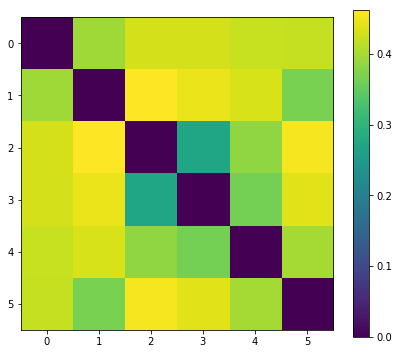

In [32]:
plt.figure(figsize=(7, 6))
plt.imshow(distance)
plt.colorbar()
plt.show()

# Fit Triplet Model

In [33]:
# fit the mode
history = triplet_model.fit_generator(train_generator, steps_per_epoch=100, epochs=50, 
                                      validation_data=val_generator, validation_steps=48, 
                                      verbose=2, callbacks=callbacks)

triplet_model.save('./models/triplet-initial-model.h5')
_ = gc.collect()

Epoch 1/50
Learning rate:  0.001
 - 72s - loss: 0.6118 - base_net_loss: 0.2022 - val_loss: 0.5998 - val_base_net_loss: 0.1998
Epoch 2/50
Learning rate:  0.001
 - 55s - loss: 0.6014 - base_net_loss: 0.2007 - val_loss: 0.5994 - val_base_net_loss: 0.2011
Epoch 3/50
Learning rate:  0.001
 - 55s - loss: 0.5999 - base_net_loss: 0.2003 - val_loss: 0.5994 - val_base_net_loss: 0.2026
Epoch 4/50
Learning rate:  0.001
 - 55s - loss: 0.6003 - base_net_loss: 0.2010 - val_loss: 0.5837 - val_base_net_loss: 0.1941
Epoch 5/50
Learning rate:  0.001
 - 55s - loss: 0.6032 - base_net_loss: 0.2075 - val_loss: 0.6003 - val_base_net_loss: 0.2010
Epoch 6/50
Learning rate:  0.001
 - 55s - loss: 0.5997 - base_net_loss: 0.1995 - val_loss: 0.6003 - val_base_net_loss: 0.2009
Epoch 7/50
Learning rate:  0.001
 - 55s - loss: 0.5996 - base_net_loss: 0.1998 - val_loss: 0.5983 - val_base_net_loss: 0.2009
Epoch 8/50
Learning rate:  0.001
 - 55s - loss: 0.6013 - base_net_loss: 0.2017 - val_loss: 0.5978 - val_base_net_loss:

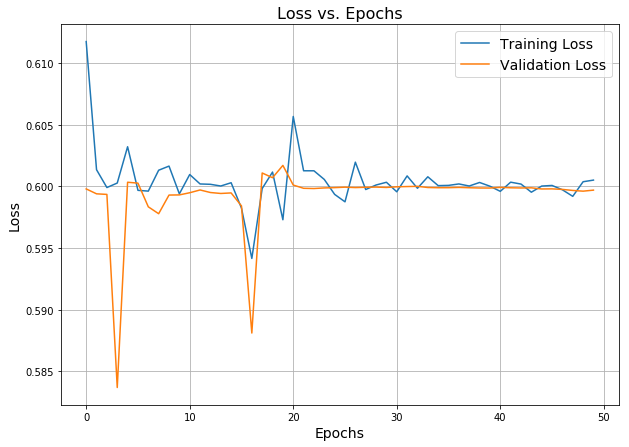

In [34]:
# Visualize the training process
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_title('Loss vs. Epochs', fontsize=16)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
plt.show()

In [35]:
base_prediction = base_model.predict(test_imgs)

base_prediction[:, :5]

array([[ 0.11955634, -0.1324915 ,  0.135236  ,  0.07976454,  0.11508806],
       [ 0.1203182 , -0.13525815,  0.13666667,  0.0811279 ,  0.11489066],
       [ 0.11893567, -0.13412024,  0.136516  ,  0.08260441,  0.11702073],
       [ 0.11849368, -0.13397767,  0.13609448,  0.08288328,  0.1174267 ],
       [ 0.11685851, -0.13478142,  0.1369994 ,  0.08107375,  0.11534099],
       [ 0.11778052, -0.1343524 ,  0.13707711,  0.08054249,  0.11386396]],
      dtype=float32)

In [36]:
distance = [[0 for j in range(6)] for i in range(6)]
for i in range(6):
    ref = base_prediction[i]
    for j in range(6):
        new_img = base_prediction[j]
        dist = np.sqrt(np.sum((new_img - ref) ** 2))
        distance[i][j] = dist
distance

[[0.0, 0.029572109, 0.024579033, 0.027173918, 0.01778125, 0.014828371],
 [0.029572109, 0.0, 0.020285645, 0.02418495, 0.02474038, 0.02498278],
 [0.024579033, 0.020285645, 0.0, 0.006565448, 0.019335138, 0.022873176],
 [0.027173918, 0.02418495, 0.006565448, 0.0, 0.020335378, 0.02477297],
 [0.01778125, 0.02474038, 0.019335138, 0.020335378, 0.0, 0.009296096],
 [0.014828371, 0.02498278, 0.022873176, 0.02477297, 0.009296096, 0.0]]

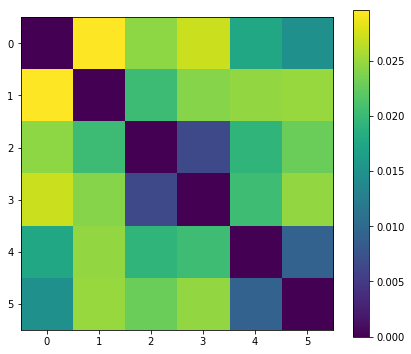

In [37]:
plt.figure(figsize=(7, 6))
plt.imshow(distance)
plt.colorbar()
plt.show()

# Extract Features using Triplet Network

In [ ]:
train_df = pd.read_csv('./data/triplet/train.csv')
val_df = pd.read_csv('./data/triplet/validation.csv')
test_df = pd.read_csv('./data/triplet/test.csv')

print('Train:\t\t', train_df.shape)
print('Validation:\t', val_df.shape)
print('Test:\t\t', test_df.shape)

print('\nTrain Landmarks:\t', len(train_df['landmark_id'].unique()))
print('Validation Landmarks:\t', len(val_df['landmark_id'].unique()))
print('Test Landmarks:\t\t', len(test_df['landmark_id'].unique()))

In [ ]:
# Define train_imgs and test_imgs
train_imgs = np.zeros(shape=(len(train_df), 128), dtype=np.float32)
val_imgs = np.zeros(shape=(len(val_df), 128), dtype=np.float32)
test_imgs = np.zeros(shape=(len(test_df), 128), dtype=np.float32)

In [ ]:
# Process training images
img_ids = train_df['image_id'].values
steps = 20000
for i in range(0, len(train_df), steps):
    tmp_imgs = []
    print('\nProcess: {:10d}'.format(i))
    
    start = i
    end = min(len(train_df), i + steps)
    for idx in range(start, end):
        if idx % 250 == 0:
            print('=', end='')
            
        img_id = img_ids[idx]
        path = './data/triplet/train/' + str(img_id) + '.jpg'
        img = load_img(path, target_size=img_size[:2])
        img = img_to_array(img)
        tmp_imgs.append(img)
        
    tmp_imgs = np.array(tmp_imgs, dtype=np.float32) / 255.0
    tmp_prediction = base_model.predict(tmp_imgs)
    train_imgs[start: end, ] = tmp_prediction
    _ = gc.collect()

In [ ]:
# Process validation images
img_ids = val_df['image_id'].values
steps = 4000
for i in range(0, len(val_df), steps):
    tmp_imgs = []
    print('\nProcess: {:10d}'.format(i))
    
    start = i
    end = min(len(val_df), i + steps)
    for idx in range(start, end):
        if idx % 50 == 0:
            print('=', end='')
            
        img_id = img_ids[idx]
        path = './data/triplet/validation/' + str(img_id) + '.jpg'
        img = load_img(path, target_size=img_size[:2])
        img = img_to_array(img)
        tmp_imgs.append(img)
        
    tmp_imgs = np.array(tmp_imgs, dtype=np.float32) / 255.0
    tmp_prediction = base_model.predict(tmp_imgs)
    val_imgs[start: end, ] = tmp_prediction
    _ = gc.collect()

In [ ]:
# Process test images
img_ids = test_df['image_id'].values
steps = 4000
for i in range(0, len(test_df), steps):
    tmp_imgs = []
    print('\nProcess: {:10d}'.format(i))
    
    start = i
    end = min(len(test_df), i + steps)
    for idx in range(start, end):
        if idx % 50 == 0:
            print('=', end='')
            
        img_id = img_ids[idx]
        path = './data/triplet/test/' + str(img_id) + '.jpg'
        img = load_img(path, target_size=img_size[:2])
        img = img_to_array(img)
        tmp_imgs.append(img)
        
    tmp_imgs = np.array(tmp_imgs, dtype=np.float32) / 255.0
    tmp_prediction = base_model.predict(tmp_imgs)
    test_imgs[start: end, ] = tmp_prediction
    _ = gc.collect()

In [ ]:
print('Train:\t\t', train_imgs.shape)
print('Validation:\t', val_imgs.shape)
print('Test:\t\t', test_imgs.shape)

In [ ]:
# Save to disk
np.save('./data/triplet/train_triplet_features.npy', train_imgs)
np.save('./data/triplet/validation_triplet_features.npy', val_imgs)
np.save('./data/triplet/test_triplet_features.npy', test_imgs)